# Extreme Gradient boosting


In [1]:
# packages used in this tutorial 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.io as scio
import math
import time
from scipy.stats import gaussian_kde
# keras is only to get boston housing data
# boston housing is also here: from sklearn.datasets import load_boston
#import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,r2_score


# gradient boosting 
from xgboost import XGBRegressor

# random forest
from sklearn.ensemble import RandomForestRegressor


/opt/anaconda3/envs/Opt/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data=scio.loadmat("trainA.mat")
input_d=data['input']
output_d=data['output']
predict_in=data['predict_in']
predict_out=data['predict_out']



In [3]:
numsize=0.7
numsample=len(input_d)

num_train=round(numsize*numsample)

X_train_df = input_d[0:num_train,1:4]
y_train_df = output_d[0:num_train,3]

X_test_df = input_d[num_train:,1:4]
y_test_df = output_d[num_train:,3]


mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

train_data=X_train_df
train_labels=y_train_df
test_data=X_test_df
test_labels=y_test_df
print(train_data.shape,test_data.shape)

(16733, 3) (7171, 3)


In [4]:
column_names = ['Day', 'Hour', 'Demand']

df = pd.DataFrame(train_data, columns=column_names)
df.head()

Day      Hour    Demand
0 -0.898733 -1.009049 -0.975330
1 -0.898733 -0.953891 -0.979187
2 -0.898733 -0.898733 -0.979584
3 -0.898733 -0.843575 -0.981739
4 -0.898733 -0.788417 -0.983060

## Labels

This is what we are trying to predict. 

In [5]:
print(train_labels[0:10])  # Display first 10 entries

[0.18705 0.17305 0.1611  0.15867 0.13314 0.1629  0.12933 0.12005 0.11733
 0.11881]


# 1. Build the model


## 1.1 define the model

 hyperparamter tuning
 
xgb_model = XGBRegressor()#thread account
cv_split = ShuffleSplit(n_splits=4, train_size=0.8, test_size=0.2,random_state=200)
param_grid = dict(
    learning_rate = np.linspace(.01, 0.2, 20)
)
start = time.time()
grid = GridSearchCV(xgb_model, param_grid, cv=cv_split, scoring='r2',n_jobs = -1,verbose=1)
grid.fit(train_data, train_labels)
print('GridSearchCV process use %.2f seconds'%(time.time()-start))
print("Best learning cure：",grid.best_params_)
print("R2",grid.best_score_)

xgb_model = XGBRegressor(learning_rate=0.09)
cv_split = ShuffleSplit(n_splits=4, train_size=0.8, test_size=0.2,random_state=2021)
param_grid = dict(
    max_depth = [3,4,5,6,7,8,9])
start = time.time()
grid = GridSearchCV(xgb_model, param_grid, cv=cv_split, scoring='r2',n_jobs = -1,verbose=1)
grid.fit(train_data, train_labels)
print('GridSearchCV process use %.2f seconds'%(time.time()-start))
print("Best tree depth",grid.best_params_)
print("R2",grid.best_score_)


xgb_model = XGBRegressor(learning_rate=0.09,max_depth=5)
cv_split = ShuffleSplit(n_splits=4, train_size=0.8, test_size=0.2,random_state=2021)
param_grid = dict(
    n_estimators = [50,100,200])
start = time.time()
grid = GridSearchCV(xgb_model, param_grid, cv=cv_split, scoring='r2',n_jobs = -1,verbose=1)
grid.fit(train_data, train_labels)
print('GridSearchCV process use %.2f seconds'%(time.time()-start))
print("Large tree numbers",grid.best_params_)
print("R2",grid.best_score_)

In [6]:
t=time.perf_counter()
#======================================================
# setup model parameters, choose RFR or XGB
# if you comment out a parameter it will use default value
#======================================================
# RFR parameters (random forest regression)
params_rfr = {'n_estimators':1000,
              'criterion':'mse', 
              #'ccp_alpha':0.001,
              'max_depth': 10,
              #'min_samples_leaf':1,
              #'min_samples_split':5,
              'bootstrap':True,
              'max_features':None}


# XGB parameters (extreme gradient boosting)
params_xgb = {'objective': 'reg:squarederror',
              #'base_score': 0.5,     # chosen as median of validation set
              'n_estimators': 100,  # number of trees to use
              'learning_rate': 0.09, #0.01
              'max_depth': 5,       # how many levels are in each tree 30
              #'subsample': 1,
              #'colsample_bytree': 0.8,
              # REGULARIZATION  alpha (L2) and lambda (L1)
              'reg_alpha': 1,
              'reg_lambda': 0,}

In [7]:
#======================================================
# define the model, uncomment the one you want to use
#======================================================
#model = RandomForestRegressor(**params_rfr)
model = XGBRegressor(**params_xgb)

## 1.2 train the model

In [8]:
%%time
evalset = [(train_data, train_labels), (test_data,test_labels)]
model.fit(train_data, train_labels,eval_metric='logloss',eval_set=evalset)


[0]	validation_0-logloss:0.67798	validation_1-logloss:0.67651
[1]	validation_0-logloss:0.66537	validation_1-logloss:0.66270
[2]	validation_0-logloss:0.65483	validation_1-logloss:0.65122
[3]	validation_0-logloss:0.64600	validation_1-logloss:0.64166
[4]	validation_0-logloss:0.63859	validation_1-logloss:0.63360
[5]	validation_0-logloss:0.63236	validation_1-logloss:0.62688
[6]	validation_0-logloss:0.62713	validation_1-logloss:0.62127
[7]	validation_0-logloss:0.62272	validation_1-logloss:0.61651
[8]	validation_0-logloss:0.61900	validation_1-logloss:0.61256
[9]	validation_0-logloss:0.61587	validation_1-logloss:0.60926
[10]	validation_0-logloss:0.61322	validation_1-logloss:0.60646
[11]	validation_0-logloss:0.61099	validation_1-logloss:0.60410
[12]	validation_0-logloss:0.60911	validation_1-logloss:0.60216
[13]	validation_0-logloss:0.60752	validation_1-logloss:0.60052
[14]	validation_0-logloss:0.60618	validation_1-logloss:0.59913
[15]	validation_0-logloss:0.60506	validation_1-logloss:0.59797
[1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.09, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=1,
             reg_lambda=0, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

# 2. Predict (using test data)

coast:0.56943004s


0.8698193343761311

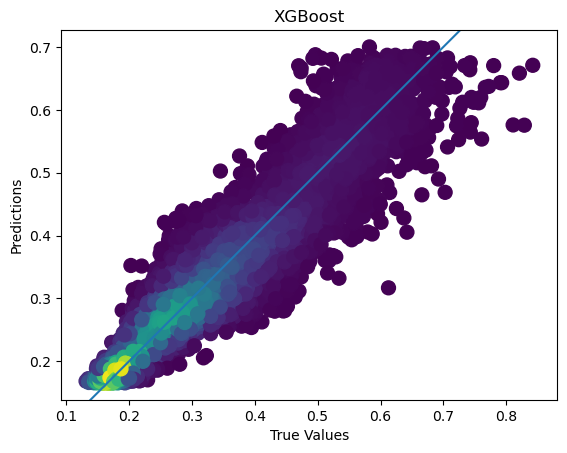

In [9]:
test_predictions = model.predict(test_data)
print(f'coast:{time.perf_counter() - t:.8f}s' )


# relationship between true and predicted value
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap

xy = np.vstack([np.transpose(test_labels),np.transpose(test_predictions)])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots()
ax.scatter(test_labels, test_predictions, c=z, s=100)
#plt.show()

#plt.scatter(y_test, y_test_pre)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.title('XGBoost')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])
from sklearn.metrics import r2_score
r2_score(test_labels,test_predictions)

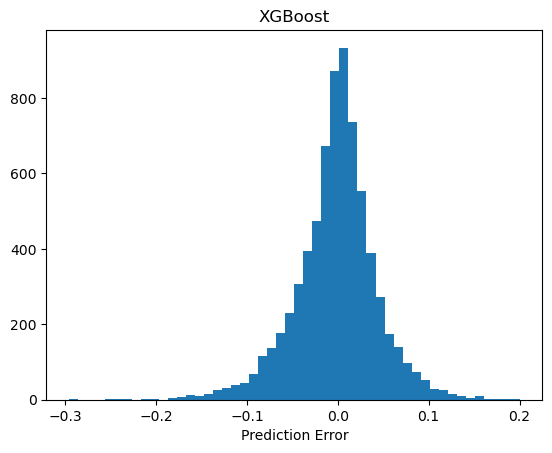

In [10]:
# histogram
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error")
plt.title('XGBoost')
plt.show()

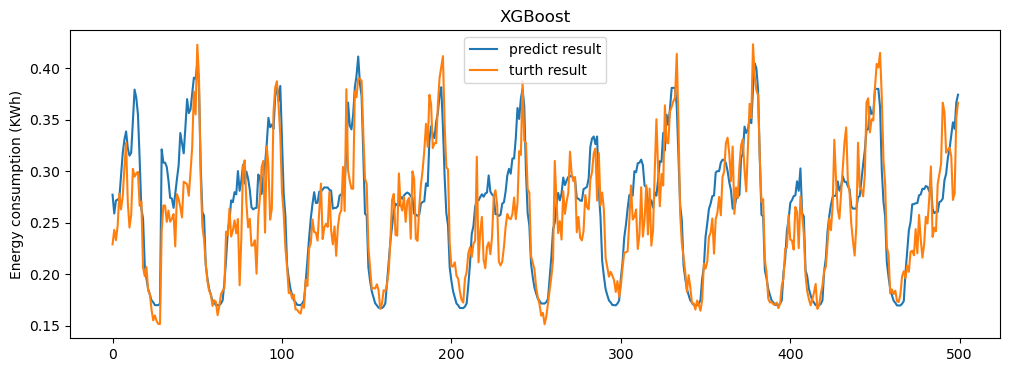

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(12,4))
x = range(0,500)
label1='predict result'
label2='turth result'
axes.plot(x, test_predictions[0:500], label=label1)
axes.set_ylabel("Energy consumption (KWh)")
axes.plot(x, test_labels[0:500], label=label2)
plt.title('XGBoost')
axes.legend()



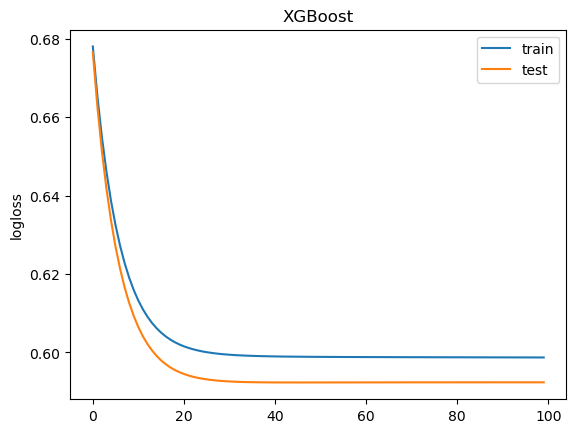

In [12]:
from matplotlib import pyplot

results = model.evals_result()
# plot learning curves
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
plt.legend()
plt.ylabel('logloss')
plt.title('XGBoost')
plt.show()

## 3. RMSE

In [13]:
mse = mean_squared_error(test_labels, test_predictions)
print(f'the mse is {mse}')
RMSE=np.sqrt(np.mean((test_predictions-test_labels)**2))
MAPE=np.mean(abs(test_labels-test_predictions)/test_labels)*100
print(RMSE,MAPE)

the mse is 0.0020333811580232736
0.045093027820532004 10.051208991987806


In [14]:
from sklearn.metrics import r2_score
r2_score(test_labels,test_predictions)

0.8698193343761311

## 4. Feature importance

In [15]:
def plot_feature_importance(importance, names):
    '''
    this code is from here: 
    https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html
    '''
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()

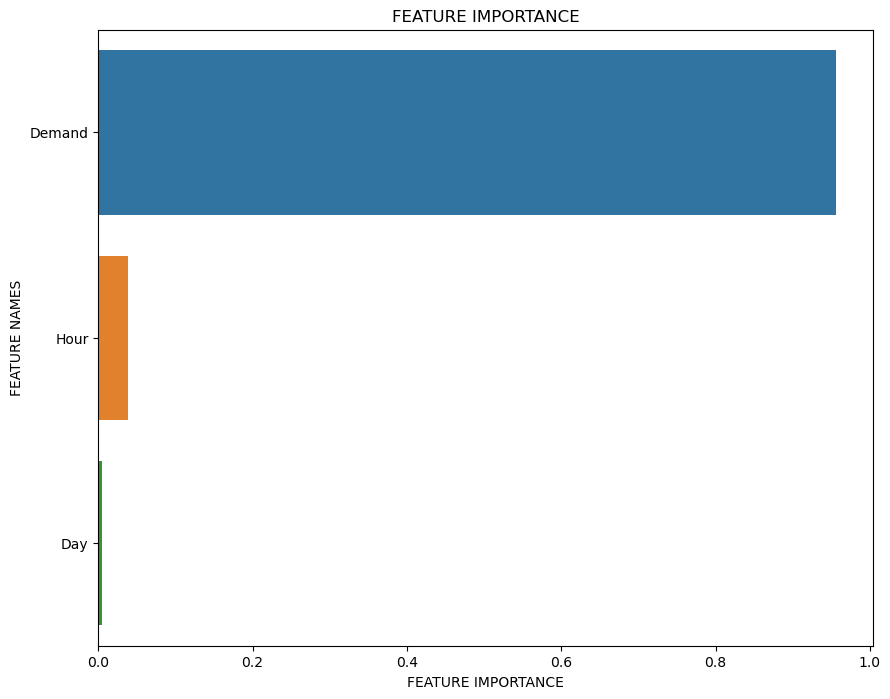

In [16]:
plot_feature_importance(model.feature_importances_, df.columns)

<AxesSubplot:>

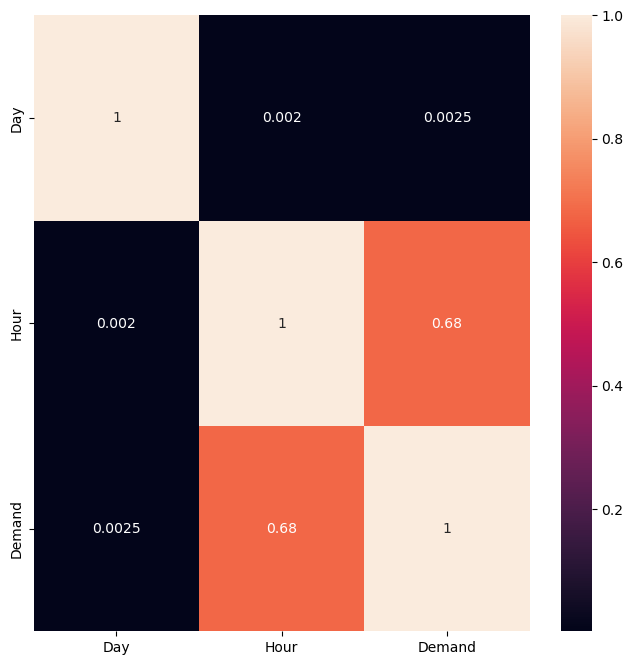

In [17]:
plt.figure(figsize=(8,8))
cor=df.corr()
sns.heatmap(cor,annot=True)
#cmap=plt.cm.Reds,fmt='.2f'

In [18]:
import shap
shap.initjs()
explainer=shap.Explainer(model)
print(explainer)
shap_value=explainer(train_data)


/opt/anaconda3/envs/Opt/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


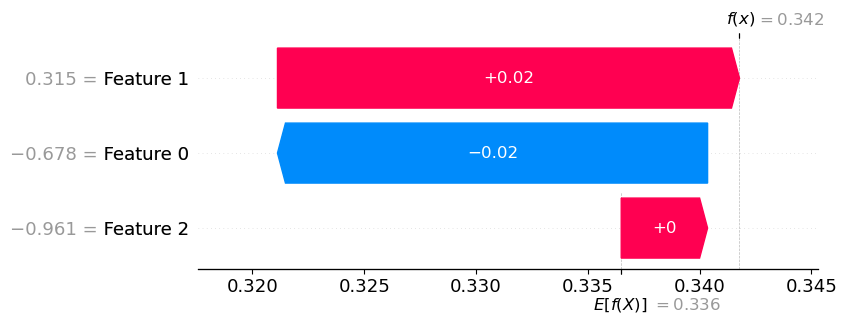

In [19]:
shap.plots.waterfall(shap_value[120])

In [20]:
shap.plots.force(explainer.expected_value,shap_value.values[:1000],shap_value.data[:1000])

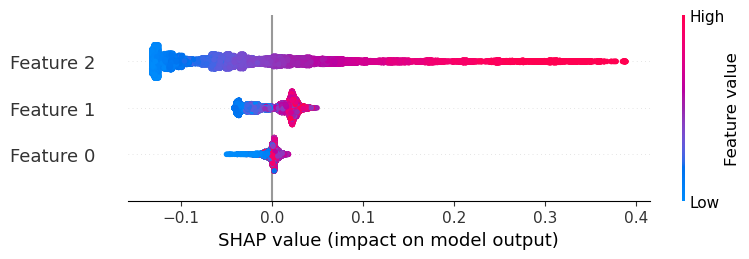

In [21]:
shap.summary_plot(shap_value, train_data)

shap_interaction = explainer.shap_interaction_values(train_data)